# TD Scikit-Learn : Régression et Classification - SOLUTIONS
## Master 2 Banque Finance Assurance - Paris Dauphine

**Durée** : 3 heures

**Objectifs** :
- Maîtriser les concepts d'overfitting, régularisation (Ridge, Lasso)
- Comprendre le processus train/validation/test et cross-validation
- Appréhender le bias-variance tradeoff
- Mesurer la performance des modèles avec les bonnes métriques
- Pratiquer scikit-learn sur des cas concrets

In [2]:
# Imports nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.datasets import fetch_california_housing, load_breast_cancer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

---
# PARTIE 1 : COURS THÉORIQUE (30 min)
---

## 1.1 Overfitting et Régularisation

### Qu'est-ce que l'overfitting ?

L'**overfitting** (surapprentissage) se produit quand un modèle apprend trop bien les données d'entraînement, incluant le bruit et les particularités spécifiques, au détriment de sa capacité de généralisation.

**Signes d'overfitting** :
- Performance excellente sur les données d'entraînement
- Performance médiocre sur les données de test
- Modèle trop complexe (trop de paramètres)

### Ridge vs Lasso : Deux approches de régularisation

La régularisation ajoute une pénalité à la fonction de coût pour contraindre les coefficients du modèle.

#### Ridge Regression (L2)
$$\text{Coût} = \text{MSE} + \alpha \sum_{i=1}^{n} \beta_i^2$$

- Pénalise le **carré** des coefficients
- Réduit les coefficients vers zéro sans les annuler
- Utile quand toutes les variables sont potentiellement pertinentes
- Gère bien la multicolinéarité

#### Lasso Regression (L1)
$$\text{Coût} = \text{MSE} + \alpha \sum_{i=1}^{n} |\beta_i|$$

- Pénalise la **valeur absolue** des coefficients
- Peut mettre certains coefficients exactement à zéro
- Effectue une **sélection de variables**
- Utile quand on pense que peu de variables sont vraiment importantes

**Paramètre α (alpha)** :
- α = 0 : pas de régularisation (régression linéaire standard)
- α petit : peu de régularisation
- α grand : forte régularisation (coefficients plus contraints)

### Illustration : Ridge vs Lasso

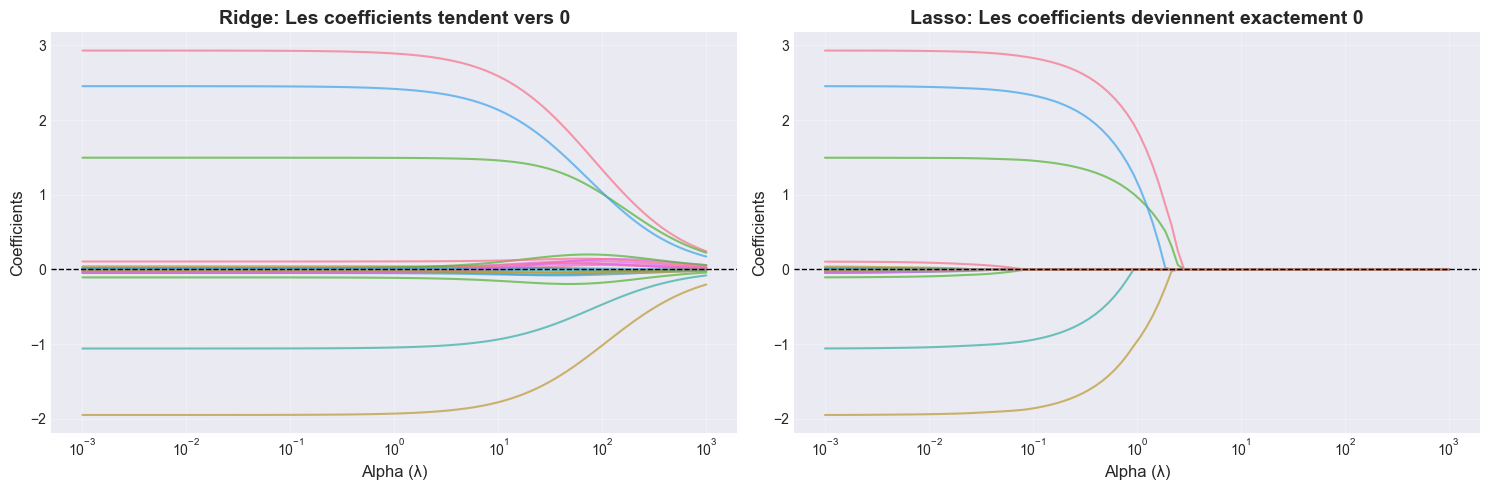

Observation : Ridge réduit progressivement tous les coefficients.
              Lasso met certains coefficients exactement à 0 (sélection de variables).


In [3]:
# Génération de données synthétiques avec des variables corrélées
np.random.seed(42)
n_samples = 100
n_features = 20

# Créer des features corrélées
X = np.random.randn(n_samples, n_features)
# Seulement 5 features sont vraiment importantes
true_coef = np.zeros(n_features)
true_coef[:5] = [3, -2, 1.5, -1, 2.5]
y = X @ true_coef + np.random.randn(n_samples) * 0.5

# Test différentes valeurs de alpha
alphas = np.logspace(-3, 3, 100)
ridge_coefs = []
lasso_coefs = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    ridge_coefs.append(ridge.coef_)
    
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X, y)
    lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ridge
for i in range(n_features):
    axes[0].plot(alphas, ridge_coefs[:, i], alpha=0.7)
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha (λ)', fontsize=12)
axes[0].set_ylabel('Coefficients', fontsize=12)
axes[0].set_title('Ridge: Les coefficients tendent vers 0', fontsize=14, fontweight='bold')
axes[0].axhline(y=0, color='k', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3)

# Lasso
for i in range(n_features):
    axes[1].plot(alphas, lasso_coefs[:, i], alpha=0.7)
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha (λ)', fontsize=12)
axes[1].set_ylabel('Coefficients', fontsize=12)
axes[1].set_title('Lasso: Les coefficients deviennent exactement 0', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observation : Ridge réduit progressivement tous les coefficients.")
print("              Lasso met certains coefficients exactement à 0 (sélection de variables).")

## 1.2 Train, Validation et Test

### Division des données

1. **Training set (60-80%)** : Entraîner le modèle
2. **Validation set (10-20%)** : Ajuster les hyperparamètres
3. **Test set (10-20%)** : Évaluation finale (ne jamais toucher avant la fin !)

### K-Fold Cross-Validation

La validation croisée divise les données en K parties (folds) :
- Entraîne sur K-1 folds
- Valide sur le fold restant
- Répète K fois en changeant le fold de validation
- Moyenne les résultats

**Avantages** :
- Utilise mieux les données (surtout si dataset petit)
- Donne une estimation plus robuste de la performance
- Détecte mieux l'overfitting

**Valeur typique** : K = 5 ou K = 10

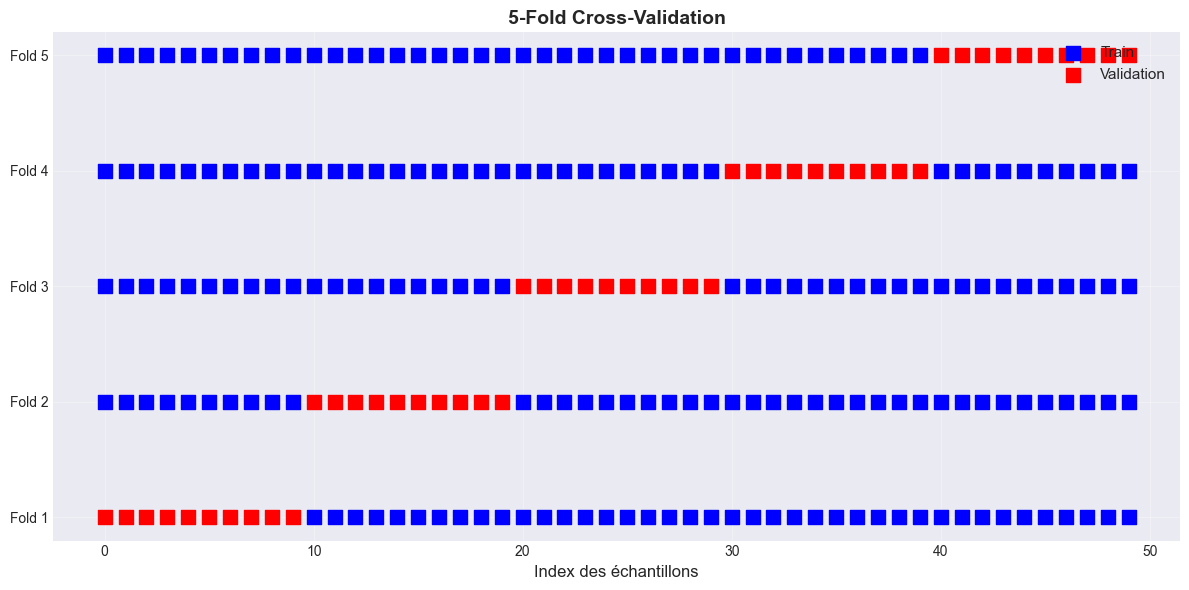

In [4]:
# Illustration de la K-Fold Cross-Validation
fig, ax = plt.subplots(figsize=(12, 6))

n_splits = 5
n_samples = 50

for i in range(n_splits):
    # Train
    train_indices = [j for j in range(n_samples) if j // (n_samples // n_splits) != i]
    ax.scatter(train_indices, [i] * len(train_indices), c='blue', marker='s', s=100, label='Train' if i == 0 else '')
    
    # Validation
    val_indices = [j for j in range(n_samples) if j // (n_samples // n_splits) == i]
    ax.scatter(val_indices, [i] * len(val_indices), c='red', marker='s', s=100, label='Validation' if i == 0 else '')

ax.set_yticks(range(n_splits))
ax.set_yticklabels([f'Fold {i+1}' for i in range(n_splits)])
ax.set_xlabel('Index des échantillons', fontsize=12)
ax.set_title('5-Fold Cross-Validation', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1.3 Bias-Variance Tradeoff

L'erreur totale d'un modèle se décompose en :

$$\text{Erreur} = \text{Bias}^2 + \text{Variance} + \text{Bruit irréductible}$$

### Bias (Biais)
- Erreur due aux **hypothèses simplificatrices** du modèle
- Modèle trop simple → **Underfitting** → Bias élevé
- Le modèle rate des patterns importants

### Variance
- Sensibilité du modèle aux **fluctuations** des données d'entraînement
- Modèle trop complexe → **Overfitting** → Variance élevée
- Le modèle apprend le bruit

### Le Tradeoff
- Réduire le bias augmente souvent la variance
- Réduire la variance augmente souvent le bias
- **Objectif** : Trouver le bon équilibre

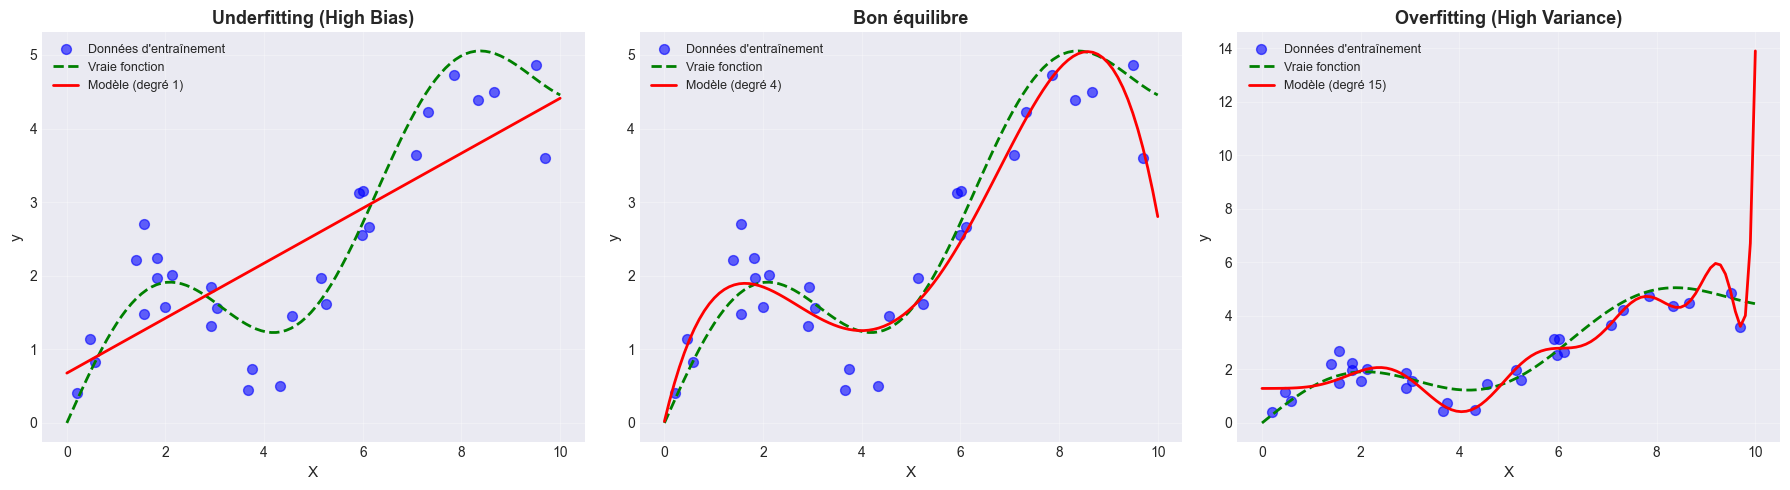

In [5]:
# Illustration du Bias-Variance Tradeoff
np.random.seed(42)

# Fonction vraie
def true_function(x):
    return np.sin(x) + 0.5 * x

# Données
X_true = np.linspace(0, 10, 100).reshape(-1, 1)
y_true = true_function(X_true).ravel()

X_train = np.random.uniform(0, 10, 30).reshape(-1, 1)
y_train = true_function(X_train).ravel() + np.random.normal(0, 0.5, X_train.shape[0])

# Modèles avec différentes complexités
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    (1, "Underfitting (High Bias)"),
    (4, "Bon équilibre"),
    (15, "Overfitting (High Variance)")
]

for idx, (degree, title) in enumerate(models):
    # Entraînement
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_train)
    model = LinearRegression()
    model.fit(X_poly, y_train)
    
    # Prédiction
    X_true_poly = poly.transform(X_true)
    y_pred = model.predict(X_true_poly)
    
    # Graphique
    axes[idx].scatter(X_train, y_train, color='blue', s=50, alpha=0.6, label='Données d\'entraînement')
    axes[idx].plot(X_true, y_true, 'g--', linewidth=2, label='Vraie fonction')
    axes[idx].plot(X_true, y_pred, 'r-', linewidth=2, label=f'Modèle (degré {degree})')
    axes[idx].set_xlabel('X', fontsize=11)
    axes[idx].set_ylabel('y', fontsize=11)
    axes[idx].set_title(title, fontsize=13, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 1.4 Métriques de Performance

### Pour la Régression

#### R² (Coefficient de détermination)
$$R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$
- Varie entre -∞ et 1 (1 = parfait)
- Proportion de variance expliquée

#### R² ajusté
$$R^2_{adj} = 1 - (1-R^2)\frac{n-1}{n-p-1}$$
- Pénalise l'ajout de variables non significatives
- Meilleur pour comparer des modèles avec nombre de variables différent

#### MSE (Mean Squared Error)
$$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$
- Pénalise fortement les grandes erreurs
- Sensible aux outliers

#### RMSE (Root Mean Squared Error)
$$RMSE = \sqrt{MSE}$$
- Même unité que la variable cible
- Plus interprétable que MSE

#### MAE (Mean Absolute Error)
$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$
- Moins sensible aux outliers que MSE

### Pour la Classification

#### Matrice de confusion
```
                Prédit Négatif    Prédit Positif
Vrai Négatif         TN                FP
Vrai Positif         FN                TP
```

#### Accuracy (Exactitude)
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$
- Proportion de prédictions correctes
- Attention aux classes déséquilibrées !

#### Precision
$$Precision = \frac{TP}{TP + FP}$$
- Parmi les prédictions positives, combien sont vraies ?
- Important quand le coût des faux positifs est élevé

#### Recall (Sensibilité)
$$Recall = \frac{TP}{TP + FN}$$
- Parmi les vrais positifs, combien sont détectés ?
- Important quand le coût des faux négatifs est élevé

#### F1-Score
$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$
- Moyenne harmonique de Precision et Recall
- Bon compromis entre les deux

#### AUC-ROC
- Aire sous la courbe ROC (True Positive Rate vs False Positive Rate)
- Mesure la capacité de discrimination du modèle
- Varie entre 0.5 (aléatoire) et 1 (parfait)

---
# PARTIE 2 : EXERCICES GUIDÉS (1h30)
---

## Exercice 1 : Régression Linéaire Simple

**Dataset** : California Housing

**Objectif** : Prédire le prix médian des maisons en Californie

**Tâches** :
1. Charger et explorer les données
2. Diviser en train/test
3. Entraîner une régression linéaire
4. Évaluer avec R², MSE, RMSE

In [6]:
# 1. Chargement des données
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

print("Shape des données :", X.shape)
print("\nPremières lignes :")
print(X.head())
print("\nStatistiques descriptives :")
print(X.describe())

Shape des données : (20640, 8)

Premières lignes :
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  

Statistiques descriptives :
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.33

In [7]:
# 2. Division train/test (80/20)
# SOLUTION:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Taille train : {X_train.shape[0]}")
print(f"Taille test : {X_test.shape[0]}")

Taille train : 16512
Taille test : 4128


In [8]:
# 3. Entraînement du modèle
# SOLUTION:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Prédictions
y_pred = model_lr.predict(X_test)

In [9]:
# 4. Évaluation
# SOLUTION:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"\nInterprétation: Le modèle explique {r2*100:.2f}% de la variance.")
print(f"Erreur moyenne: {rmse:.2f} (en centaines de milliers de dollars)")

R² Score: 0.5758
MSE: 0.5559
RMSE: 0.7456

Interprétation: Le modèle explique 57.58% de la variance.
Erreur moyenne: 0.75 (en centaines de milliers de dollars)


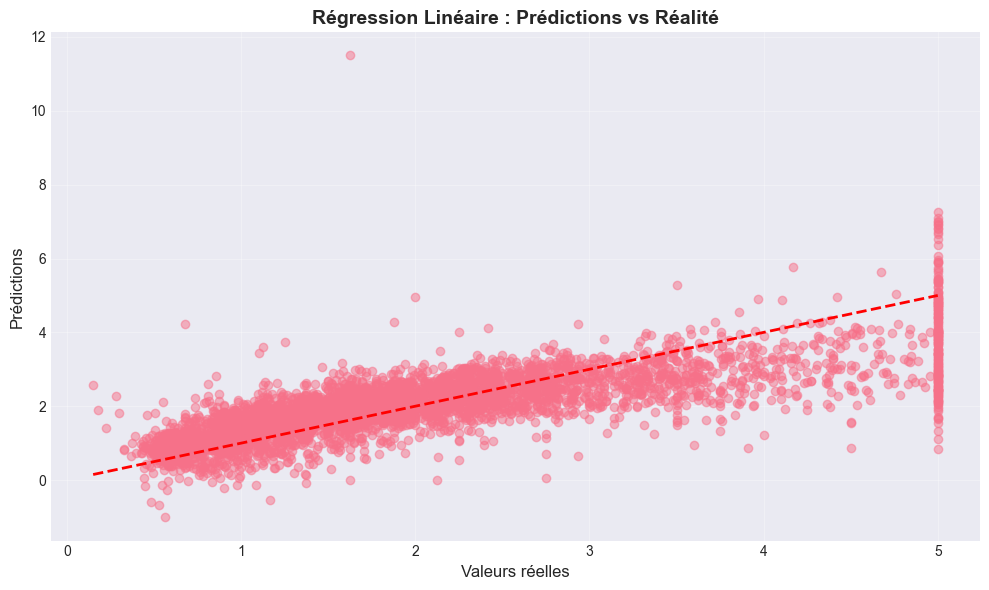

In [10]:
# Visualisation : Prédictions vs Valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valeurs réelles', fontsize=12)
plt.ylabel('Prédictions', fontsize=12)
plt.title('Régression Linéaire : Prédictions vs Réalité', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Exercice 2 : Régression Polynomiale et Overfitting

**Objectif** : Observer l'impact du degré polynomial sur l'overfitting

**Tâches** :
1. Générer des données synthétiques
2. Tester différents degrés polynomiaux (1, 2, 5, 15)
3. Comparer les performances train vs test
4. Identifier le modèle qui overfitte

In [11]:
# 1. Génération de données synthétiques
np.random.seed(42)
X_synth = np.sort(np.random.rand(100, 1) * 10, axis=0)
y_synth = 2 + 3*X_synth.ravel() - 0.5*X_synth.ravel()**2 + np.random.randn(100) * 2

# Division train/test
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_synth, y_synth, test_size=0.3, random_state=42)

In [12]:
# 2. Test de différents degrés
# SOLUTION:
degrees = [1, 2, 5, 15]
results = []

for degree in degrees:
    # Création du Pipeline
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    
    # Entraînement
    model.fit(X_train_s, y_train_s)
    
    # Scores
    train_score = model.score(X_train_s, y_train_s)
    test_score = model.score(X_test_s, y_test_s)
    
    results.append({
        'degree': degree,
        'train_r2': train_score,
        'test_r2': test_score
    })

results_df = pd.DataFrame(results)
print(results_df)

   degree  train_r2   test_r2
0       1  0.630362  0.610155
1       2  0.926558  0.927590
2       5  0.927064  0.927819
3      15  0.927422  0.925516


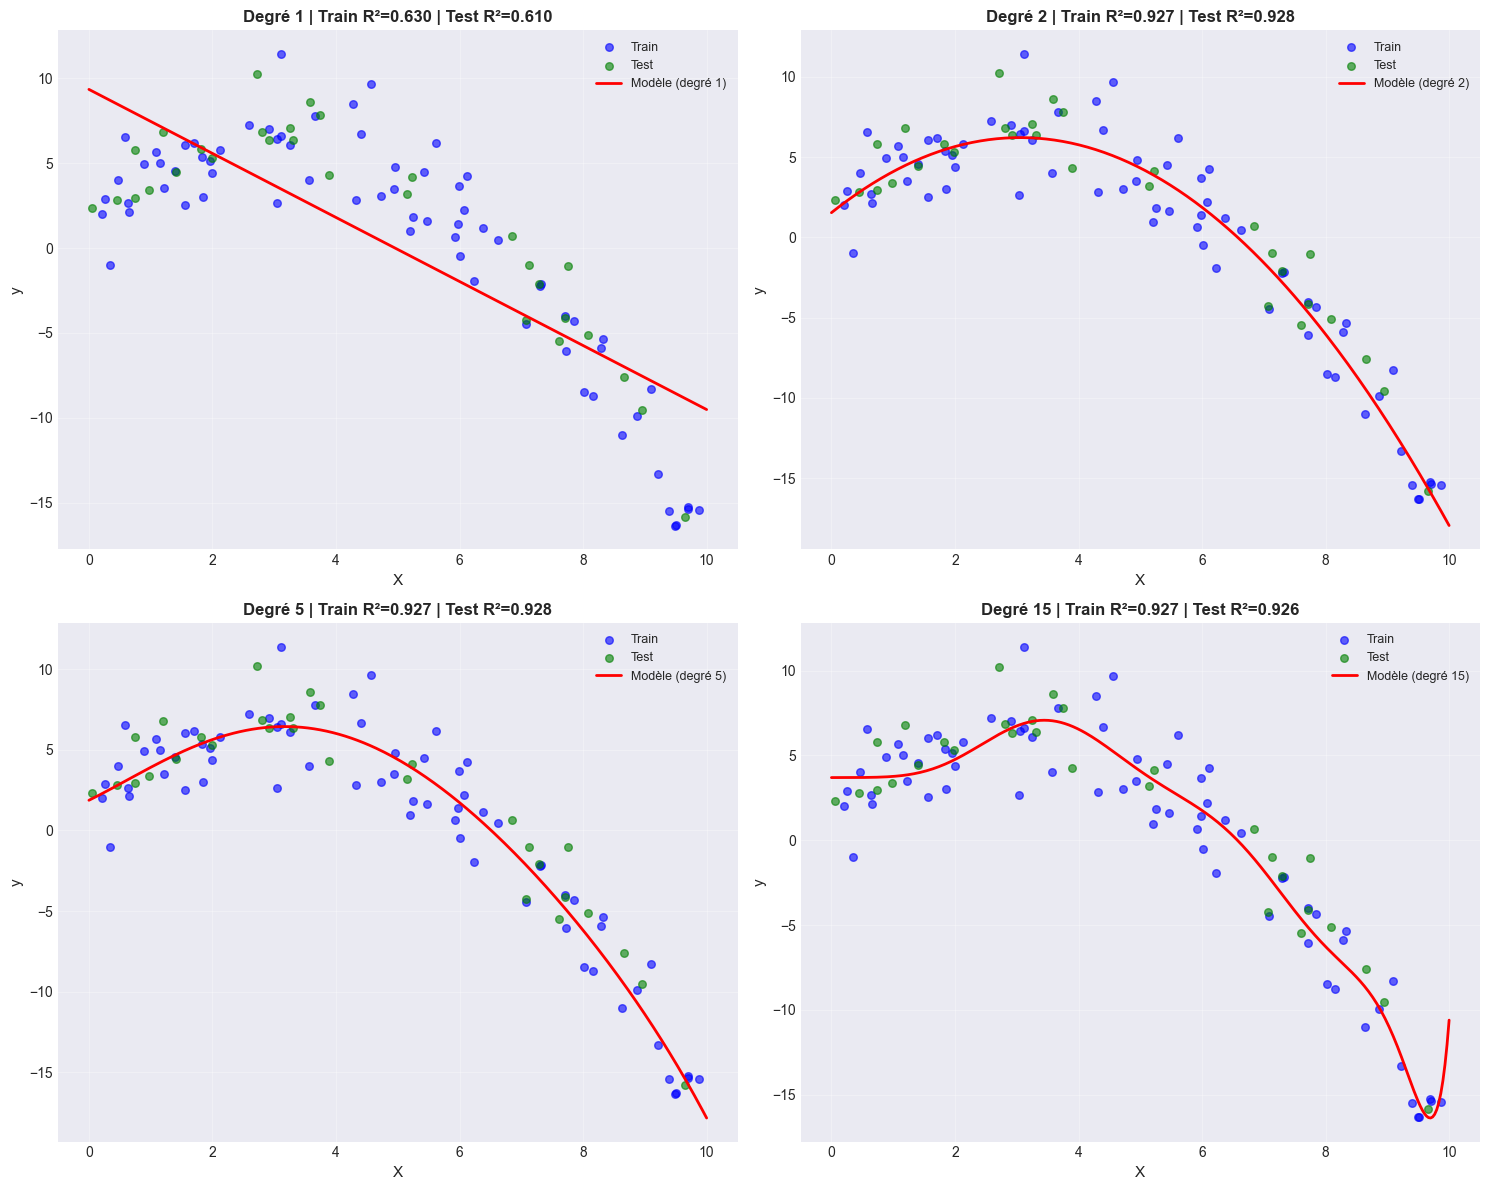


📊 Analyse :
- Degré 1-2 : Underfitting (scores train et test bas)
- Degré 5 : Bon équilibre
- Degré 15 : Overfitting (score train élevé, score test faible)


In [13]:
# 3. Visualisation
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

X_plot = np.linspace(0, 10, 300).reshape(-1, 1)

for idx, degree in enumerate(degrees):
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)), ('linear', LinearRegression())])
    model.fit(X_train_s, y_train_s)
    y_plot = model.predict(X_plot)
    
    train_r2 = results_df.loc[results_df['degree'] == degree, 'train_r2'].values[0]
    test_r2 = results_df.loc[results_df['degree'] == degree, 'test_r2'].values[0]
    
    axes[idx].scatter(X_train_s, y_train_s, color='blue', s=30, alpha=0.6, label='Train')
    axes[idx].scatter(X_test_s, y_test_s, color='green', s=30, alpha=0.6, label='Test')
    axes[idx].plot(X_plot, y_plot, 'r-', linewidth=2, label=f'Modèle (degré {degree})')
    axes[idx].set_xlabel('X', fontsize=11)
    axes[idx].set_ylabel('y', fontsize=11)
    axes[idx].set_title(f'Degré {degree} | Train R²={train_r2:.3f} | Test R²={test_r2:.3f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Analyse :")
print("- Degré 1-2 : Underfitting (scores train et test bas)")
print("- Degré 5 : Bon équilibre")
print("- Degré 15 : Overfitting (score train élevé, score test faible)")

## Exercice 3 : Ridge vs Lasso avec GridSearchCV

**Objectif** : Comparer Ridge et Lasso et trouver le meilleur α par validation croisée

**Tâches** :
1. Utiliser les données California Housing
2. Standardiser les features
3. Utiliser GridSearchCV pour trouver le meilleur α
4. Comparer les coefficients Ridge vs Lasso

In [14]:
# 1. Préparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SOLUTION: Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
?scaler.transform

Signature: scaler.transform(X, copy=None)
Docstring:
Perform standardization by centering and scaling.

Parameters
----------
X : {array-like, sparse matrix of shape (n_samples, n_features)
    The data used to scale along the features axis.
copy : bool, default=None
    Copy the input X or not.

Returns
-------
X_tr : {ndarray, sparse matrix} of shape (n_samples, n_features)
    Transformed array.
File:      c:\users\ahuss\downloads\ml_course\ml_course_bfa3\2026\venv\lib\site-packages\sklearn\preprocessing\_data.py
Type:      method

In [16]:
# 2. GridSearchCV pour Ridge
# SOLUTION:
param_grid = {'alpha': np.logspace(-3, 3, 20)}

grid_ridge = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
grid_ridge.fit(X_train_scaled, y_train)

print("Meilleur alpha Ridge:", grid_ridge.best_params_)
print("Meilleur score Ridge:", grid_ridge.best_score_)

Meilleur alpha Ridge: {'alpha': np.float64(0.001)}
Meilleur score Ridge: 0.6114839952527685


In [17]:
# 3. GridSearchCV pour Lasso
# SOLUTION:
grid_lasso = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, scoring='r2')
grid_lasso.fit(X_train_scaled, y_train)

print("Meilleur alpha Lasso:", grid_lasso.best_params_)
print("Meilleur score Lasso:", grid_lasso.best_score_)

Meilleur alpha Lasso: {'alpha': np.float64(0.001)}
Meilleur score Lasso: 0.6114974494713218



Comparaison des coefficients :
      Feature     Ridge     Lasso
0      MedInc  0.854383  0.849140
1    HouseAge  0.122546  0.123346
2    AveRooms -0.294410 -0.281273
3   AveBedrms  0.339259  0.326050
4  Population -0.002308 -0.001062
5    AveOccup -0.040829 -0.039890
6    Latitude -0.896928 -0.885822
7   Longitude -0.869841 -0.858093


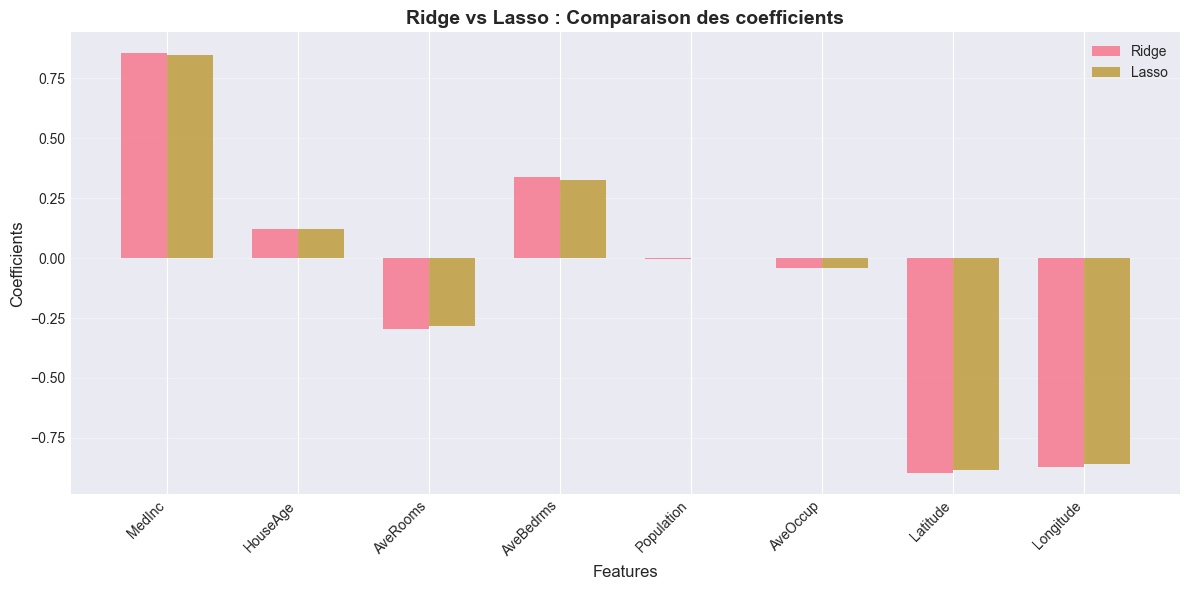


Nombre de coefficients non-nuls - Ridge: 8
Nombre de coefficients non-nuls - Lasso: 8


In [18]:
# 4. Comparaison des coefficients
ridge_coef = grid_ridge.best_estimator_.coef_
lasso_coef = grid_lasso.best_estimator_.coef_

# Visualisation
coef_df = pd.DataFrame({
    'Feature': housing.feature_names,
    'Ridge': ridge_coef,
    'Lasso': lasso_coef
})

print("\nComparaison des coefficients :")
print(coef_df)

# Graphique
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(housing.feature_names))
width = 0.35

ax.bar(x_pos - width/2, ridge_coef, width, label='Ridge', alpha=0.8)
ax.bar(x_pos + width/2, lasso_coef, width, label='Lasso', alpha=0.8)

ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Coefficients', fontsize=12)
ax.set_title('Ridge vs Lasso : Comparaison des coefficients', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(housing.feature_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nNombre de coefficients non-nuls - Ridge: {np.sum(ridge_coef != 0)}")
print(f"Nombre de coefficients non-nuls - Lasso: {np.sum(lasso_coef != 0)}")

## Exercice 4 : Régression Logistique et Métriques de Classification

**Dataset** : Breast Cancer Wisconsin

**Objectif** : Classifier les tumeurs (bénignes vs malignes)

**Tâches** :
1. Charger et préparer les données
2. Entraîner une régression logistique
3. Calculer toutes les métriques : Accuracy, Precision, Recall, F1, AUC-ROC
4. Afficher la matrice de confusion et la courbe ROC

In [19]:
# 1. Chargement des données
cancer = load_breast_cancer()
X_cancer = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_cancer = cancer.target

print("Classes:", cancer.target_names)
print("Nombre d'échantillons:", X_cancer.shape[0])
print("Nombre de features:", X_cancer.shape[1])
print("\nDistribution des classes:")
print(pd.Series(y_cancer).value_counts())

Classes: ['malignant' 'benign']
Nombre d'échantillons: 569
Nombre de features: 30

Distribution des classes:
1    357
0    212
Name: count, dtype: int64


In [20]:
# 2. Préparation et entraînement
# SOLUTION:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cancer, y_cancer, test_size=0.2, random_state=42)

# Standardisation
scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

# Entraînement
model_log = LogisticRegression(max_iter=10000, random_state=42)
model_log.fit(X_train_c_scaled, y_train_c)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [21]:
# 3. Prédictions
# SOLUTION:
y_pred_c = model_log.predict(X_test_c_scaled)
y_pred_proba = model_log.predict_proba(X_test_c_scaled)[:, 1]

In [22]:
# 4. Calcul des métriques
# SOLUTION:
accuracy = accuracy_score(y_test_c, y_pred_c)
precision = precision_score(y_test_c, y_pred_c)
recall = recall_score(y_test_c, y_pred_c)
f1 = f1_score(y_test_c, y_pred_c)
auc_roc = roc_auc_score(y_test_c, y_pred_proba)

print("=" * 50)
print("MÉTRIQUES DE CLASSIFICATION")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc_roc:.4f}")
print("=" * 50)

MÉTRIQUES DE CLASSIFICATION
Accuracy:  0.9737
Precision: 0.9722
Recall:    0.9859
F1-Score:  0.9790
AUC-ROC:   0.9974


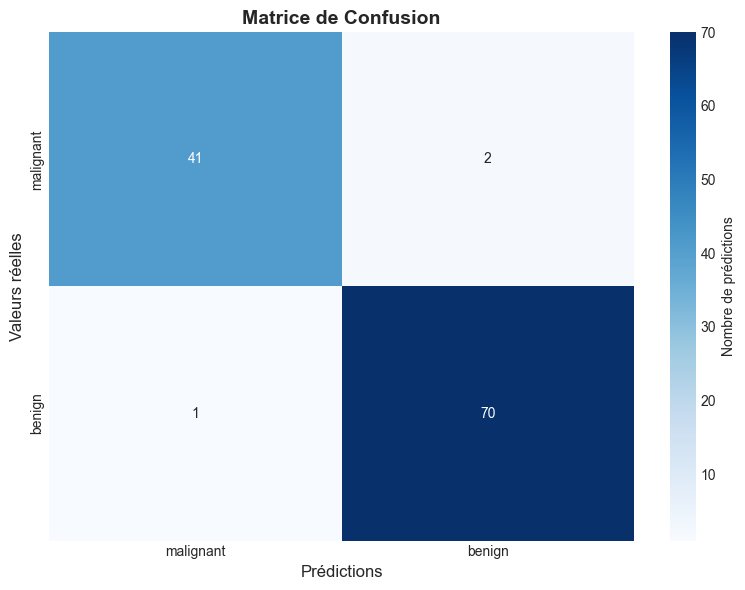


Interprétation de la matrice de confusion:
True Negatives (TN):  41
False Positives (FP): 2
False Negatives (FN): 1
True Positives (TP):  70


In [23]:
# 5. Matrice de confusion
cm = confusion_matrix(y_test_c, y_pred_c)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cancer.target_names, 
            yticklabels=cancer.target_names,
            cbar_kws={'label': 'Nombre de prédictions'})
plt.xlabel('Prédictions', fontsize=12)
plt.ylabel('Valeurs réelles', fontsize=12)
plt.title('Matrice de Confusion', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterprétation de la matrice de confusion:")
print(f"True Negatives (TN):  {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP):  {cm[1,1]}")

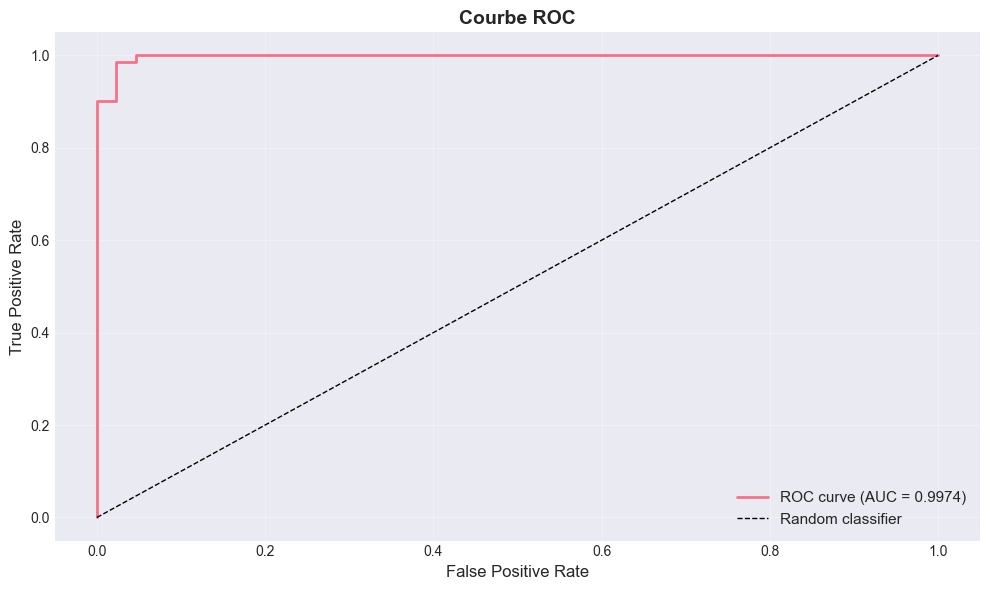

In [24]:
# 6. Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_c, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Courbe ROC', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Exercice 5 : K-Fold Cross-Validation Complète

**Objectif** : Utiliser la K-Fold CV pour une évaluation robuste

**Tâches** :
1. Implémenter une K-Fold CV manuelle (K=5)
2. Utiliser cross_val_score de scikit-learn
3. Comparer les résultats
4. Visualiser la variabilité des scores

In [25]:
# On utilise les données California Housing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# 1. K-Fold CV manuelle
# SOLUTION:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
manual_scores = []

for train_idx, val_idx in kf.split(X_train_scaled):
    # Séparation des données
    X_train_fold = X_train_scaled[train_idx]
    X_val_fold = X_train_scaled[val_idx]
    y_train_fold = y_train.iloc[train_idx] if isinstance(y_train, pd.Series) else y_train[train_idx]
    y_val_fold = y_train.iloc[val_idx] if isinstance(y_train, pd.Series) else y_train[val_idx]
    
    # Entraînement
    model = Ridge(alpha=1.0)
    model.fit(X_train_fold, y_train_fold)
    
    # Score
    score = model.score(X_val_fold, y_val_fold)
    manual_scores.append(score)

print(f"Scores manuels (5 folds): {manual_scores}")
print(f"Score moyen: {np.mean(manual_scores):.4f} (+/- {np.std(manual_scores):.4f})")

Scores manuels (5 folds): [0.6096978310761281, 0.604124359933839, 0.6354298011791004, 0.6007588061375281, 0.6072766028280314]
Score moyen: 0.6115 (+/- 0.0124)


In [27]:
# 2. Avec cross_val_score
# SOLUTION:
model_ridge = Ridge(alpha=1.0)
cv_scores = cross_val_score(model_ridge, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"\nScores avec cross_val_score: {cv_scores}")
print(f"Score moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Scores avec cross_val_score: [0.62010998 0.61298705 0.61343295 0.61070059 0.60018886]
Score moyen: 0.6115 (+/- 0.0065)


In [28]:
# 3. Comparaison de différents modèles avec CV
# SOLUTION:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=0.1)': Ridge(alpha=0.1),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Ridge (α=10)': Ridge(alpha=10),
    'Lasso (α=0.1)': Lasso(alpha=0.1, max_iter=10000)
}

results_cv = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    results_cv[name] = scores

# Affichage des résultats
print("\n" + "="*60)
print("COMPARAISON DES MODÈLES (5-Fold Cross-Validation)")
print("="*60)
for name, scores in results_cv.items():
    print(f"{name:25s} | Score moyen: {scores.mean():.4f} (+/- {scores.std():.4f})")
print("="*60)


COMPARAISON DES MODÈLES (5-Fold Cross-Validation)
Linear Regression         | Score moyen: 0.6115 (+/- 0.0065)
Ridge (α=0.1)             | Score moyen: 0.6115 (+/- 0.0065)
Ridge (α=1.0)             | Score moyen: 0.6115 (+/- 0.0065)
Ridge (α=10)              | Score moyen: 0.6115 (+/- 0.0064)
Lasso (α=0.1)             | Score moyen: 0.4971 (+/- 0.0041)


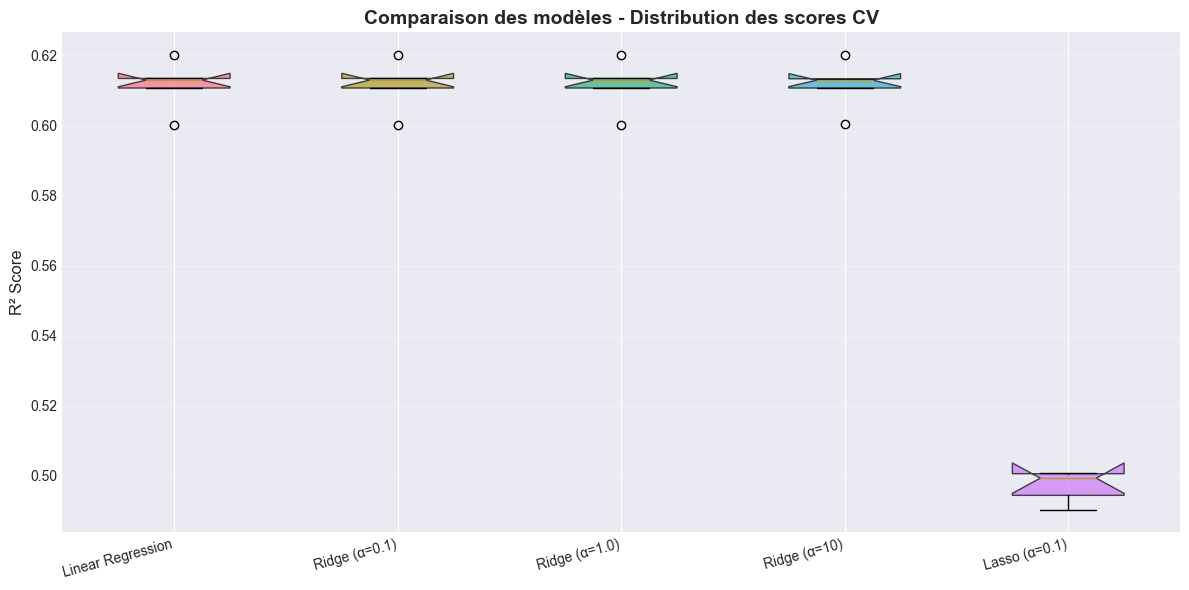

In [29]:
# 4. Visualisation
plt.figure(figsize=(12, 6))
bp = plt.boxplot([results_cv[name] for name in models.keys()], 
                  labels=models.keys(),
                  patch_artist=True,
                  notch=True)

# Coloration des boîtes
colors = sns.color_palette("husl", len(models))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('R² Score', fontsize=12)
plt.title('Comparaison des modèles - Distribution des scores CV', fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

---
# PARTIE 3 : PROJET AUTONOME (1h) - SOLUTION
---

## Projet : Prédiction de Défaut de Crédit

### Contexte
Vous travaillez pour une banque qui souhaite prédire si un client va faire défaut sur son prêt. Vous disposez de données historiques sur des clients avec diverses caractéristiques financières.

### Dataset
Les données contiennent :
- **Variables financières** : revenu, ratio dette/revenu, montant du prêt, etc.
- **Variables démographiques** : âge, statut d'emploi, etc.
- **Historique de crédit** : nombre de prêts, défauts précédents, etc.
- **Cible** : défaut (1) ou non (0)

In [30]:
# Génération du dataset de crédit
np.random.seed(42)
n_samples = 2000

# Features
age = np.random.normal(40, 12, n_samples)
income = np.random.lognormal(10.5, 0.5, n_samples)  # en milliers
debt_ratio = np.random.beta(2, 5, n_samples)
credit_score = np.random.normal(650, 80, n_samples)
loan_amount = np.random.lognormal(10, 0.8, n_samples)  # en milliers
employment_length = np.random.exponential(5, n_samples)
num_credit_lines = np.random.poisson(3, n_samples)
num_late_payments = np.random.poisson(1, n_samples)
previous_defaults = np.random.binomial(1, 0.15, n_samples)

# Création de la cible avec une logique réaliste
default_prob = 1 / (1 + np.exp(-(
    -5 
    + 0.02 * (age - 40) 
    - 0.0002 * income
    + 3 * debt_ratio
    - 0.008 * credit_score
    + 0.0003 * loan_amount
    - 0.1 * employment_length
    + 0.3 * num_late_payments
    + 1.5 * previous_defaults
)))

default = (np.random.rand(n_samples) < default_prob).astype(int)

# Création du DataFrame
credit_data = pd.DataFrame({
    'age': age,
    'income': income,
    'debt_ratio': debt_ratio,
    'credit_score': credit_score,
    'loan_amount': loan_amount,
    'employment_length': employment_length,
    'num_credit_lines': num_credit_lines,
    'num_late_payments': num_late_payments,
    'previous_defaults': previous_defaults,
    'default': default
})

print("Dataset de crédit créé avec succès!")
print(f"Shape: {credit_data.shape}")
print(f"\nTaux de défaut: {default.mean()*100:.2f}%")
print("\nPremières lignes:")
print(credit_data.head())

Dataset de crédit créé avec succès!
Shape: (2000, 10)

Taux de défaut: 14.20%

Premières lignes:
         age        income  debt_ratio  credit_score   loan_amount  \
0  45.960570  25910.688929    0.145306    672.474280  18172.799451   
1  38.340828  33783.934730    0.069270    714.719089  40711.869212   
2  47.772262  24435.445449    0.152696    737.564996  18851.207884   
3  58.276358  31132.863212    0.119140    748.919161  22631.464229   
4  37.190160  14089.606354    0.307747    799.611095  15080.854354   

   employment_length  num_credit_lines  num_late_payments  previous_defaults  \
0           7.511291                 4                  0                  0   
1           4.349879                 2                  0                  0   
2           1.688823                 3                  0                  0   
3           6.623463                 3                  0                  0   
4           4.447512                 5                  2                  0   

 

### 1. EXPLORATION DES DONNÉES

In [31]:
# SOLUTION: Statistiques descriptives
print("=" * 70)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 70)
print(credit_data.describe())

# Vérifier les valeurs manquantes
print("\n" + "=" * 70)
print("VALEURS MANQUANTES")
print("=" * 70)
print(credit_data.isnull().sum())

# Distribution de la cible
print("\n" + "=" * 70)
print("DISTRIBUTION DE LA VARIABLE CIBLE")
print("=" * 70)
print(credit_data['default'].value_counts())
print(f"\nProportion de défauts: {credit_data['default'].mean()*100:.2f}%")

STATISTIQUES DESCRIPTIVES
               age         income   debt_ratio  credit_score    loan_amount  \
count  2000.000000    2000.000000  2000.000000   2000.000000    2000.000000   
mean     40.541010   41092.216981     0.287598    651.415114   31103.894709   
std      11.861588   22249.067041     0.158767     80.393957   28731.678674   
min       1.104792    8024.413988     0.006476    384.310836    1202.117445   
25%      32.528057   25474.596521     0.166595    598.375679   13011.981380   
50%      40.536300   36314.535117     0.265303    650.874316   22687.548349   
75%      48.195731   50653.917258     0.393352    703.003881   38856.012281   
max      86.232778  258620.975353     0.819733    924.312838  305156.174154   

       employment_length  num_credit_lines  num_late_payments  \
count        2000.000000       2000.000000         2000.00000   
mean            5.099108          2.983500            1.00100   
std             5.126405          1.724446            0.99423   
mi

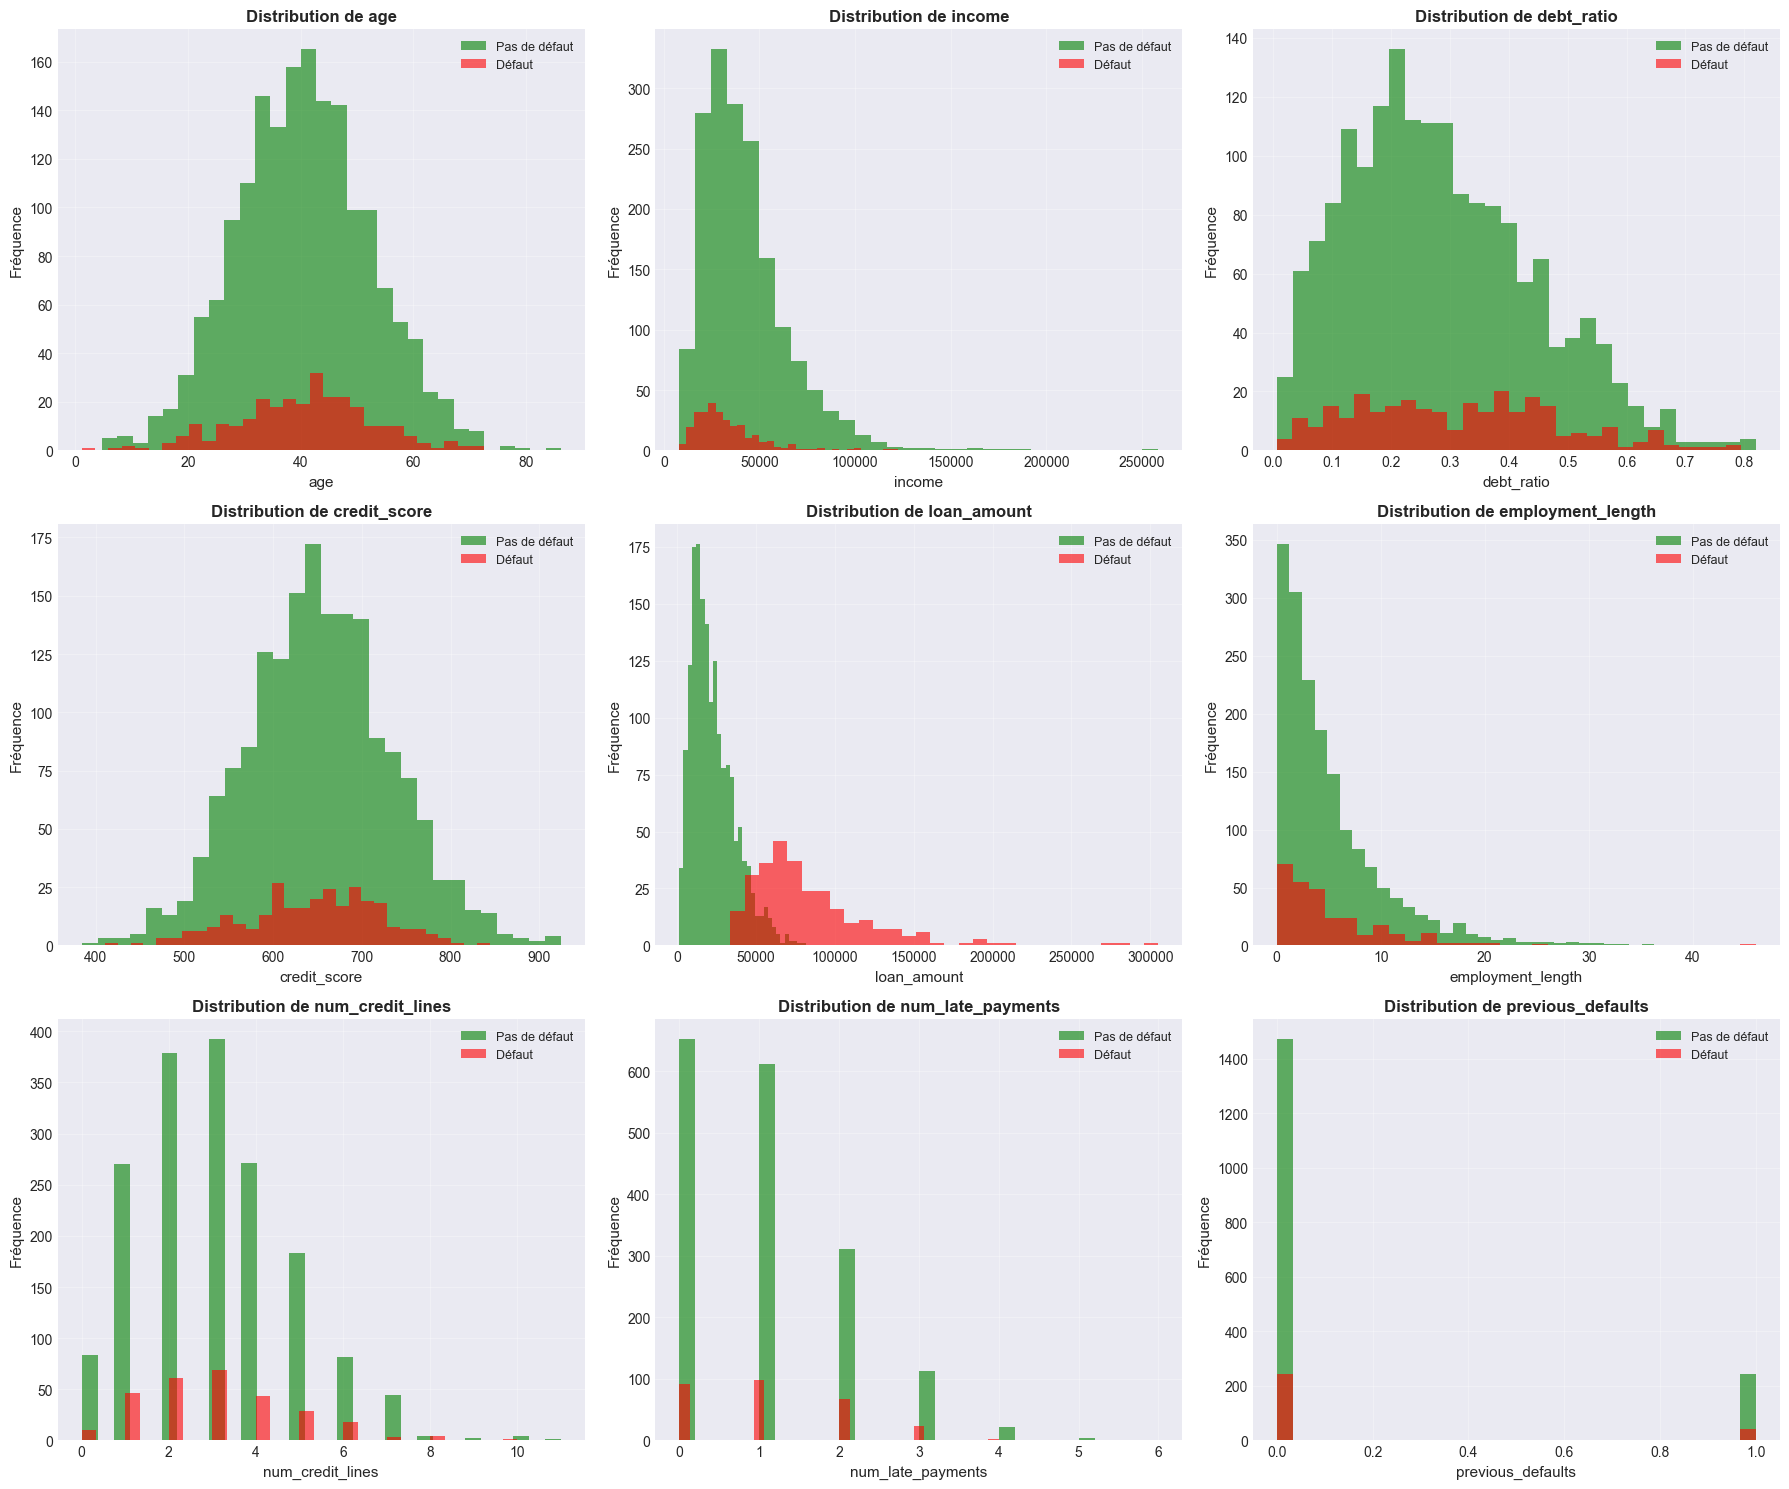

In [32]:
# Visualisations
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

features = credit_data.columns[:-1]  # Toutes sauf 'default'

for idx, col in enumerate(features):
    axes[idx].hist(credit_data[credit_data['default']==0][col], alpha=0.6, label='Pas de défaut', bins=30, color='green')
    axes[idx].hist(credit_data[credit_data['default']==1][col], alpha=0.6, label='Défaut', bins=30, color='red')
    axes[idx].set_xlabel(col, fontsize=11)
    axes[idx].set_ylabel('Fréquence', fontsize=11)
    axes[idx].set_title(f'Distribution de {col}', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

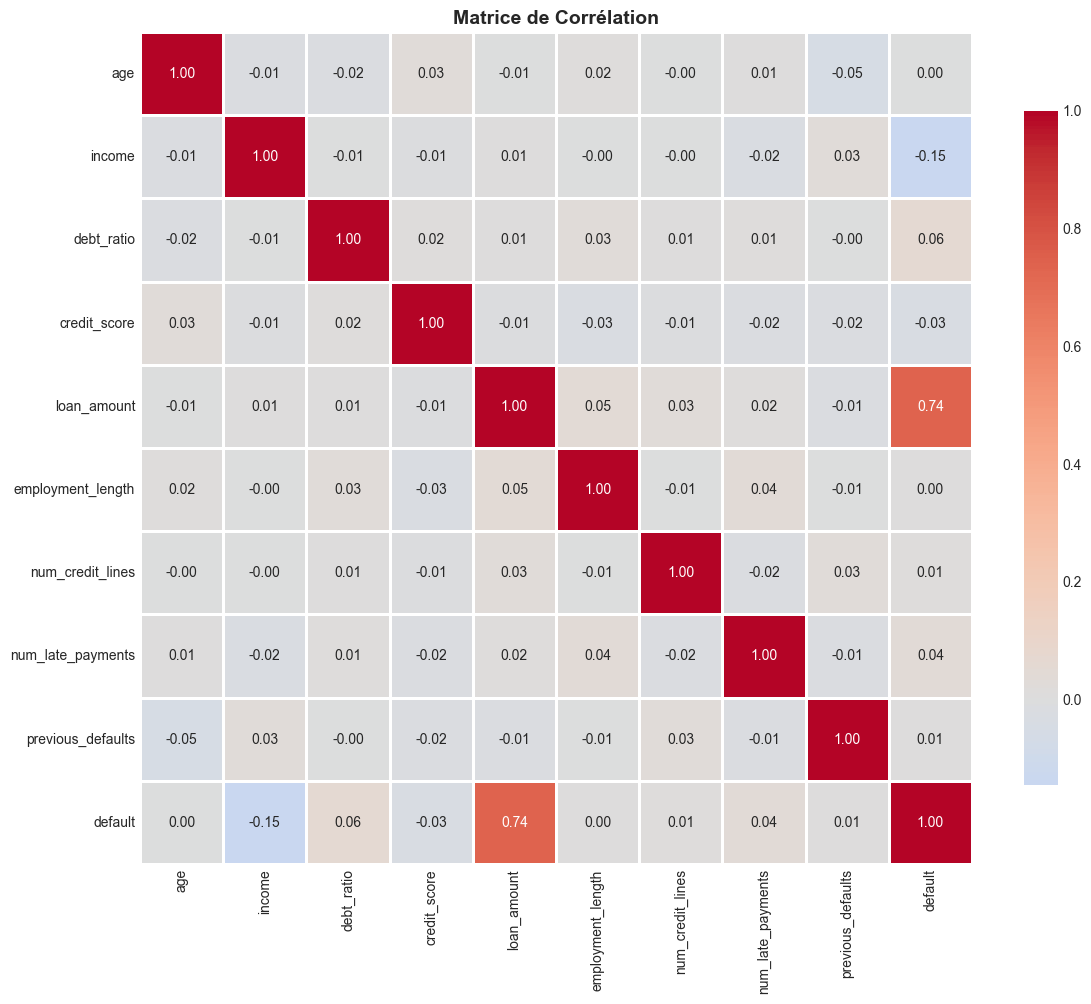


Corrélations avec la variable cible (default):
default              1.000000
loan_amount          0.736467
debt_ratio           0.061479
num_late_payments    0.041384
num_credit_lines     0.013033
previous_defaults    0.005091
employment_length    0.003422
age                  0.000324
credit_score        -0.034246
income              -0.146649
Name: default, dtype: float64


In [33]:
# Matrice de corrélation
plt.figure(figsize=(12, 10))
corr_matrix = credit_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrélations avec la variable cible (default):")
print(corr_matrix['default'].sort_values(ascending=False))

### 2. PRÉPARATION DES DONNÉES

In [34]:
# SOLUTION: Séparation X et y
X_credit = credit_data.drop('default', axis=1)
y_credit = credit_data['default']

# Division train/test (80/20)
X_train_cr, X_test_cr, y_train_cr, y_test_cr = train_test_split(
    X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit
)

# Standardisation
scaler_cr = StandardScaler()
X_train_cr_scaled = scaler_cr.fit_transform(X_train_cr)
X_test_cr_scaled = scaler_cr.transform(X_test_cr)

print(f"Taille train: {X_train_cr.shape[0]}")
print(f"Taille test: {X_test_cr.shape[0]}")
print(f"\nDistribution dans le train: {y_train_cr.value_counts()}")
print(f"\nDistribution dans le test: {y_test_cr.value_counts()}")

Taille train: 1600
Taille test: 400

Distribution dans le train: default
0    1373
1     227
Name: count, dtype: int64

Distribution dans le test: default
0    343
1     57
Name: count, dtype: int64


### 3. MODÈLE 1 : Régression Logistique Simple

In [35]:
# SOLUTION:
model_log_simple = LogisticRegression(max_iter=10000, random_state=42)
model_log_simple.fit(X_train_cr_scaled, y_train_cr)

# Prédictions
y_pred_simple = model_log_simple.predict(X_test_cr_scaled)
y_pred_proba_simple = model_log_simple.predict_proba(X_test_cr_scaled)[:, 1]

# Métriques
print("=" * 70)
print("MODÈLE 1: RÉGRESSION LOGISTIQUE SIMPLE")
print("=" * 70)
print(f"Accuracy:  {accuracy_score(y_test_cr, y_pred_simple):.4f}")
print(f"Precision: {precision_score(y_test_cr, y_pred_simple):.4f}")
print(f"Recall:    {recall_score(y_test_cr, y_pred_simple):.4f}")
print(f"F1-Score:  {f1_score(y_test_cr, y_pred_simple):.4f}")
print(f"AUC-ROC:   {roc_auc_score(y_test_cr, y_pred_proba_simple):.4f}")

# Cross-validation
cv_scores_simple = cross_val_score(model_log_simple, X_train_cr_scaled, y_train_cr, cv=5, scoring='roc_auc')
print(f"\nCV AUC-ROC: {cv_scores_simple.mean():.4f} (+/- {cv_scores_simple.std():.4f})")

MODÈLE 1: RÉGRESSION LOGISTIQUE SIMPLE
Accuracy:  0.9850
Precision: 0.9811
Recall:    0.9123
F1-Score:  0.9455
AUC-ROC:   0.9984

CV AUC-ROC: 0.9961 (+/- 0.0009)


### 4. MODÈLE 2 : Régression Logistique avec Régularisation

In [36]:
# SOLUTION: GridSearchCV pour trouver le meilleur C (inverse de alpha)
param_grid_log = {
    'C': np.logspace(-3, 3, 20),  # C est l'inverse de alpha
    'penalty': ['l1', 'l2']
}

grid_log = GridSearchCV(
    LogisticRegression(max_iter=10000, solver='liblinear', random_state=42),
    param_grid_log,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_log.fit(X_train_cr_scaled, y_train_cr)

print("=" * 70)
print("MODÈLE 2: RÉGRESSION LOGISTIQUE AVEC RÉGULARISATION")
print("=" * 70)
print(f"Meilleurs paramètres: {grid_log.best_params_}")
print(f"Meilleur score CV: {grid_log.best_score_:.4f}")

# Évaluation sur le test
y_pred_reg = grid_log.predict(X_test_cr_scaled)
y_pred_proba_reg = grid_log.predict_proba(X_test_cr_scaled)[:, 1]

print(f"\nPerformance sur le test:")
print(f"Accuracy:  {accuracy_score(y_test_cr, y_pred_reg):.4f}")
print(f"Precision: {precision_score(y_test_cr, y_pred_reg):.4f}")
print(f"Recall:    {recall_score(y_test_cr, y_pred_reg):.4f}")
print(f"F1-Score:  {f1_score(y_test_cr, y_pred_reg):.4f}")
print(f"AUC-ROC:   {roc_auc_score(y_test_cr, y_pred_proba_reg):.4f}")

MODÈLE 2: RÉGRESSION LOGISTIQUE AVEC RÉGULARISATION
Meilleurs paramètres: {'C': np.float64(0.6951927961775606), 'penalty': 'l2'}
Meilleur score CV: 0.9963

Performance sur le test:
Accuracy:  0.9850
Precision: 0.9811
Recall:    0.9123
F1-Score:  0.9455
AUC-ROC:   0.9985


### 5. MODÈLE 3 : Régression Logistique Polynomiale

In [37]:
# SOLUTION: Pipeline avec PolynomialFeatures
pipeline_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('log', LogisticRegression(max_iter=10000, C=1.0, random_state=42))
])

pipeline_poly.fit(X_train_cr, y_train_cr)

# Prédictions
y_pred_poly = pipeline_poly.predict(X_test_cr)
y_pred_proba_poly = pipeline_poly.predict_proba(X_test_cr)[:, 1]

print("=" * 70)
print("MODÈLE 3: RÉGRESSION LOGISTIQUE POLYNOMIALE (DEGRÉ 2)")
print("=" * 70)
print(f"Accuracy:  {accuracy_score(y_test_cr, y_pred_poly):.4f}")
print(f"Precision: {precision_score(y_test_cr, y_pred_poly):.4f}")
print(f"Recall:    {recall_score(y_test_cr, y_pred_poly):.4f}")
print(f"F1-Score:  {f1_score(y_test_cr, y_pred_poly):.4f}")
print(f"AUC-ROC:   {roc_auc_score(y_test_cr, y_pred_proba_poly):.4f}")

# Cross-validation
cv_scores_poly = cross_val_score(pipeline_poly, X_train_cr, y_train_cr, cv=5, scoring='roc_auc')
print(f"\nCV AUC-ROC: {cv_scores_poly.mean():.4f} (+/- {cv_scores_poly.std():.4f})")

MODÈLE 3: RÉGRESSION LOGISTIQUE POLYNOMIALE (DEGRÉ 2)
Accuracy:  0.9825
Precision: 0.9808
Recall:    0.8947
F1-Score:  0.9358
AUC-ROC:   0.9942

CV AUC-ROC: 0.9947 (+/- 0.0017)


### 6. COMPARAISON DES MODÈLES

In [38]:
# SOLUTION: Tableau comparatif
comparison_data = {
    'Modèle': ['Logistique Simple', 'Logistique Régularisée', 'Logistique Polynomiale'],
    'Accuracy': [
        accuracy_score(y_test_cr, y_pred_simple),
        accuracy_score(y_test_cr, y_pred_reg),
        accuracy_score(y_test_cr, y_pred_poly)
    ],
    'Precision': [
        precision_score(y_test_cr, y_pred_simple),
        precision_score(y_test_cr, y_pred_reg),
        precision_score(y_test_cr, y_pred_poly)
    ],
    'Recall': [
        recall_score(y_test_cr, y_pred_simple),
        recall_score(y_test_cr, y_pred_reg),
        recall_score(y_test_cr, y_pred_poly)
    ],
    'F1-Score': [
        f1_score(y_test_cr, y_pred_simple),
        f1_score(y_test_cr, y_pred_reg),
        f1_score(y_test_cr, y_pred_poly)
    ],
    'AUC-ROC': [
        roc_auc_score(y_test_cr, y_pred_proba_simple),
        roc_auc_score(y_test_cr, y_pred_proba_reg),
        roc_auc_score(y_test_cr, y_pred_proba_poly)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 100)
print("COMPARAISON DES MODÈLES")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)


COMPARAISON DES MODÈLES
                Modèle  Accuracy  Precision   Recall  F1-Score  AUC-ROC
     Logistique Simple    0.9850   0.981132 0.912281  0.945455 0.998414
Logistique Régularisée    0.9850   0.981132 0.912281  0.945455 0.998466
Logistique Polynomiale    0.9825   0.980769 0.894737  0.935780 0.994220


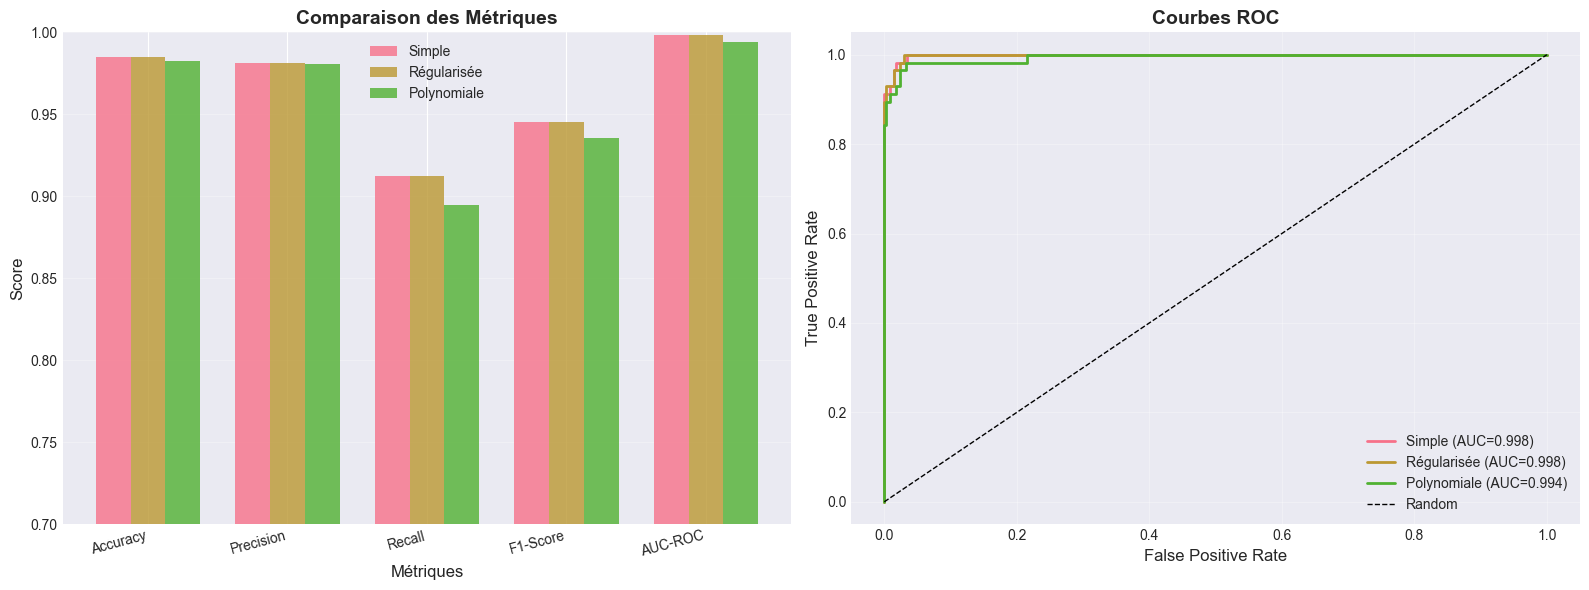

In [39]:
# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Comparaison des métriques
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x = np.arange(len(metrics))
width = 0.25

axes[0].bar(x - width, comparison_df.iloc[0, 1:], width, label='Simple', alpha=0.8)
axes[0].bar(x, comparison_df.iloc[1, 1:], width, label='Régularisée', alpha=0.8)
axes[0].bar(x + width, comparison_df.iloc[2, 1:], width, label='Polynomiale', alpha=0.8)

axes[0].set_xlabel('Métriques', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Comparaison des Métriques', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.7, 1.0])

# Graphique 2: Courbes ROC
fpr_simple, tpr_simple, _ = roc_curve(y_test_cr, y_pred_proba_simple)
fpr_reg, tpr_reg, _ = roc_curve(y_test_cr, y_pred_proba_reg)
fpr_poly, tpr_poly, _ = roc_curve(y_test_cr, y_pred_proba_poly)

axes[1].plot(fpr_simple, tpr_simple, linewidth=2, 
             label=f'Simple (AUC={roc_auc_score(y_test_cr, y_pred_proba_simple):.3f})')
axes[1].plot(fpr_reg, tpr_reg, linewidth=2, 
             label=f'Régularisée (AUC={roc_auc_score(y_test_cr, y_pred_proba_reg):.3f})')
axes[1].plot(fpr_poly, tpr_poly, linewidth=2, 
             label=f'Polynomiale (AUC={roc_auc_score(y_test_cr, y_pred_proba_poly):.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')

axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('Courbes ROC', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7. INTERPRÉTATION ET RECOMMANDATIONS


IMPORTANCE DES VARIABLES (COEFFICIENTS)
             Feature  Coefficient
4        loan_amount     4.816702
1             income    -2.190248
2         debt_ratio     0.500095
5  employment_length    -0.361767
3       credit_score    -0.271822
8  previous_defaults     0.209397
0                age     0.209014
7  num_late_payments     0.198613
6   num_credit_lines    -0.040988


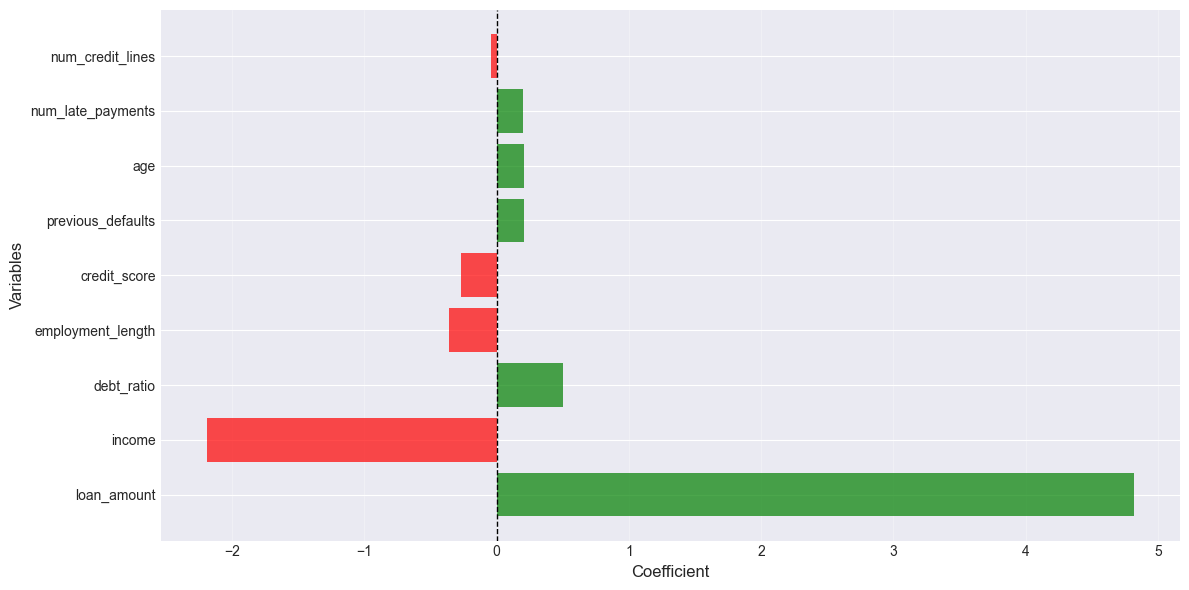

In [40]:
# SOLUTION: Analyse des coefficients du meilleur modèle
# On prend le modèle régularisé qui semble être le meilleur
best_model = grid_log.best_estimator_
feature_importance = pd.DataFrame({
    'Feature': X_credit.columns,
    'Coefficient': best_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n" + "=" * 70)
print("IMPORTANCE DES VARIABLES (COEFFICIENTS)")
print("=" * 70)
print(feature_importance)

# Visualisation
plt.figure(figsize=(12, 6))
colors = ['red' if x < 0 else 'green' for x in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

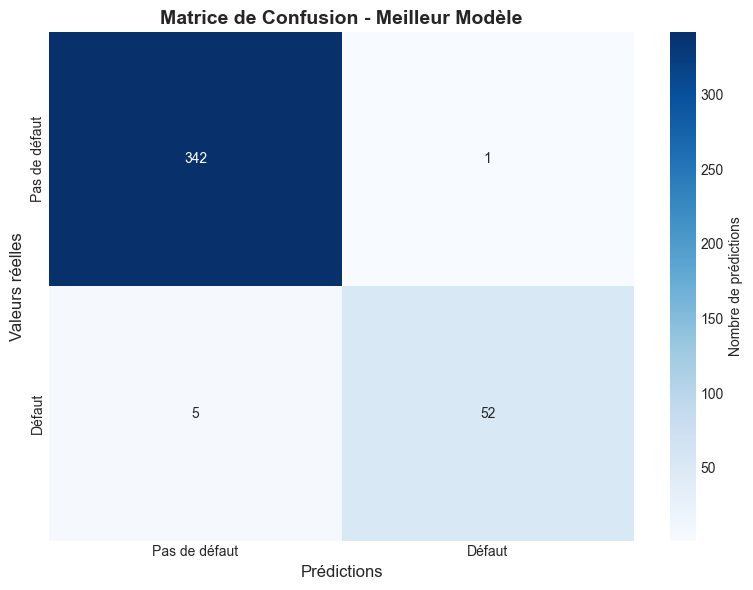


ANALYSE DES ERREURS
True Negatives (TN):  342 - Clients sans défaut correctement identifiés
False Positives (FP): 1 - Bons clients rejetés (coût d'opportunité)
False Negatives (FN): 5 - Mauvais clients acceptés (perte financière)
True Positives (TP):  52 - Clients à risque correctement identifiés


In [41]:
# Matrice de confusion du meilleur modèle
cm_best = confusion_matrix(y_test_cr, y_pred_reg)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pas de défaut', 'Défaut'],
            yticklabels=['Pas de défaut', 'Défaut'],
            cbar_kws={'label': 'Nombre de prédictions'})
plt.xlabel('Prédictions', fontsize=12)
plt.ylabel('Valeurs réelles', fontsize=12)
plt.title('Matrice de Confusion - Meilleur Modèle', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyse des erreurs
print("\n" + "=" * 70)
print("ANALYSE DES ERREURS")
print("=" * 70)
print(f"True Negatives (TN):  {cm_best[0,0]} - Clients sans défaut correctement identifiés")
print(f"False Positives (FP): {cm_best[0,1]} - Bons clients rejetés (coût d'opportunité)")
print(f"False Negatives (FN): {cm_best[1,0]} - Mauvais clients acceptés (perte financière)")
print(f"True Positives (TP):  {cm_best[1,1]} - Clients à risque correctement identifiés")

### RECOMMANDATIONS FINALES

In [42]:
print("\n" + "="*100)
print("RECOMMANDATIONS POUR LA BANQUE")
print("="*100)

print("\n1. CHOIX DU MODÈLE:")
print("-" * 50)
print("Le modèle de régression logistique avec régularisation est recommandé.")
print(f"- Pénalité: {grid_log.best_params_['penalty'].upper()}")
print(f"- Paramètre C: {grid_log.best_params_['C']:.4f}")
print(f"- AUC-ROC: {roc_auc_score(y_test_cr, y_pred_proba_reg):.4f}")
print("\nRaisons:")
print("  • Bon équilibre entre performance et interprétabilité")
print("  • Évite l'overfitting grâce à la régularisation")
print("  • Les coefficients sont facilement interprétables pour les décideurs")

print("\n2. VARIABLES CLÉS À SURVEILLER:")
print("-" * 50)
top_features = feature_importance.head(5)
for idx, row in top_features.iterrows():
    print(f"  • {row['Feature']:25s}: (coef={row['Coefficient']:+.4f})")

print("\n3. CONTEXTE MÉTIER - COÛTS:")
print("-" * 50)
print("Dans le contexte bancaire:")
print("  • Faux Négatif (FN): Coût ÉLEVÉ - Accepter un client qui fera défaut")
print("    → Perte du montant du prêt + coûts de recouvrement")
print("  • Faux Positif (FP): Coût MODÉRÉ - Rejeter un bon client")
print("    → Perte d'opportunité commerciale")
print(f"\nNotre modèle: {cm_best[1,0]} FN vs {cm_best[0,1]} FP")
print("→ Bon équilibre avec une légère préférence pour éviter les FN")

print("\n4. STRATÉGIE DE DÉPLOIEMENT:")
print("-" * 50)
print("  1. Utiliser le modèle comme outil d'aide à la décision (pas automatisation totale)")
print("  2. Définir des seuils de probabilité selon l'appétit au risque:")
print("     - Seuil conservateur (0.3): Minimiser les défauts")
print("     - Seuil équilibré (0.5): Compromis actuel")
print("     - Seuil agressif (0.7): Maximiser les acceptations")
print("  3. Surveillance continue des performances (recalibrage trimestriel)")
print("  4. Intégrer l'expertise humaine pour les cas limites")

print("\n5. AMÉLIORATIONS FUTURES:")
print("-" * 50)
print("  • Collecter plus de données sur l'historique de paiement")
print("  • Intégrer des variables macroéconomiques (taux d'intérêt, chômage)")
print("  • Tester des modèles plus sophistiqués (Gradient Boosting, Neural Networks)")
print("  • Implémenter un système de scoring dynamique")
print("  • Analyser les biais potentiels (age, genre) pour éviter la discrimination")

print("\n" + "="*100)
print("FIN DU PROJET")
print("="*100)


RECOMMANDATIONS POUR LA BANQUE

1. CHOIX DU MODÈLE:
--------------------------------------------------
Le modèle de régression logistique avec régularisation est recommandé.
- Pénalité: L2
- Paramètre C: 0.6952
- AUC-ROC: 0.9985

Raisons:
  • Bon équilibre entre performance et interprétabilité
  • Évite l'overfitting grâce à la régularisation
  • Les coefficients sont facilement interprétables pour les décideurs

2. VARIABLES CLÉS À SURVEILLER:
--------------------------------------------------
  • loan_amount              : (coef=+4.8167)
  • income                   : (coef=-2.1902)
  • debt_ratio               : (coef=+0.5001)
  • employment_length        : (coef=-0.3618)
  • credit_score             : (coef=-0.2718)

3. CONTEXTE MÉTIER - COÛTS:
--------------------------------------------------
Dans le contexte bancaire:
  • Faux Négatif (FN): Coût ÉLEVÉ - Accepter un client qui fera défaut
    → Perte du montant du prêt + coûts de recouvrement
  • Faux Positif (FP): Coût MODÉRÉ -

---
## Fin du TD

### Points clés à retenir

1. **Overfitting** : Toujours comparer performance train vs test
2. **Régularisation** : Ridge pour réduire les coefficients, Lasso pour sélectionner les variables
3. **Cross-validation** : Donne une estimation plus robuste de la performance
4. **Métriques** : Choisir les métriques adaptées au problème et au contexte métier
5. **Pipeline** : Automatiser les étapes de préparation et de modélisation

### Pour aller plus loin

- Documentation scikit-learn : https://scikit-learn.org/
- Elastic Net : combinaison de Ridge et Lasso